## **Notebook 02 — RFM Construction & K-Means Clustering**

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

________
### ***1. Load and Prepare Data***
### ***This section loads the cleaned transactional dataset and converts the `InvoiceDate` column into datetime format for time-based calculations.***

In [53]:
df = pd.read_csv("DF_cleaned.csv", index_col=0)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [54]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


________
### ***2. Load RFM Table***
### ***The preprocessed RFM dataset is imported.***

In [55]:
rfm = pd.read_csv("RFM_cleaned.csv", index_col=0)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


### ***Only the standard RFM metrics (Recency, Frequency, Monetary) are used for clustering.***

In [56]:
X = rfm[["Recency", "Frequency", "Monetary"]].values

________
### ***3. Scale RFM Features***
### ***K-Means is sensitive to feature scale. We standardize the RFM values using StandardScaler to ensure equal weight in clustering.***

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

________
### ***4. Apply K-Means Clustering***
### ***K-Means is trained on the scaled RFM features. The predicted cluster labels are appended to the RFM table.***

In [58]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
kmeans.fit(X_scaled)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [59]:
labels = kmeans.predict(X_scaled)
rfm["Cluster"] = labels

In [60]:
rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,1
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,1


________
### ***5. Merge Cluster Labels with the Main Dataset***
### ***Cluster assignments are added to the transactional dataset to enable further time-based and behavioral analysis.***

In [61]:
df = df.merge(rfm, left_on="CustomerID", right_index=True, how="left")

In [62]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTotal,Recency,Frequency,Monetary,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,372,34,5391.21,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,372,34,5391.21,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,372,34,5391.21,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,372,34,5391.21,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,372,34,5391.21,1


________
### ***6. Cluster Summary***
### ***Descriptive statistics of each cluster are calculated to interpret customer segments using mean values of Recency, Frequency, and Monetary.***

In [63]:
cluster_summery = rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean()
cluster_summery = cluster_summery.round(2)
cluster_summery

,Recency,Frequency,Monetary
Cluster,,,
0,40.98,4.85,2012.11
1,246.02,1.58,631.14
2,7.14,80.21,122888.41


________
### ***7. Define Reference Date***
### ***A reference date is generated by adding a 90-day buffer to the most recent invoice date. This is used to define the Target (return vs. churn) variable.***

In [64]:
label_reference_date = (df["InvoiceDate"].max()) + (pd.Timedelta(days=90))
label_reference_date

Timestamp('2012-03-08 12:50:00')

________
### ***8. Create Target Variable***
### ***A churn label is created based on the time gap between the last two purchases:***
- ***Gap ≤ 90 days → Returning Customer (1)***
- ***Gap > 90 days → Churned Customer (0)***

In [65]:
last_purchase = df.groupby("CustomerID")["InvoiceDate"].max()
second_last_purchase = df.groupby("CustomerID")["InvoiceDate"].nth(-2)
gap = (last_purchase - second_last_purchase).dt.days

In [66]:
target = (gap <= 90).astype(int)
rfm["Target"] = target

________
### ***9. Build Modeling Dataset***
### ***We construct the final ML dataset including:***
- ***Recency***
- ***Frequency***
- ***Monetary***
- ***Cluster label***
- ***Target variable***

In [67]:
recency = (label_reference_date - last_purchase).dt.days
frequency = df.groupby("CustomerID")["InvoiceNo"].nunique()
monetary = df.groupby("CustomerID")["InvoiceTotal"].sum()

In [68]:
model_df = pd.DataFrame({
    "Recency": recency,
    "Frequency": frequency,
    "Monetary": monetary,
    "Cluster": rfm["Cluster"],
    "Target": target
})

In [69]:
model_df.head(10)

,Recency,Frequency,Monetary,Cluster,Target
166.0,NaN,NaN,NaN,NaN,0
385.0,NaN,NaN,NaN,NaN,0
539.0,NaN,NaN,NaN,NaN,0
700.0,NaN,NaN,NaN,NaN,0
864.0,NaN,NaN,NaN,NaN,0
1014.0,NaN,NaN,NaN,NaN,0
1188.0,NaN,NaN,NaN,NaN,0
1318.0,NaN,NaN,NaN,NaN,0
1344.0,NaN,NaN,NaN,NaN,0
1402.0,NaN,NaN,NaN,NaN,0


In [70]:
rfm["Target"] = (rfm["Recency"] <= 90).astype(int)
rfm["Target"].value_counts()

Target
1    2889
0    1449
Name: count, dtype: int64

### ***Missing values are removed and the final dataset is validated for completeness.***

In [71]:
model_df.isna().sum()

Recency      4256
Frequency    4256
Monetary     4256
Cluster      4256
Target          0
dtype: int64

In [72]:
model_df.shape

(8594, 5)

In [73]:
model_df = pd.concat([recency, frequency, monetary, rfm["Cluster"], target], axis=1)
model_df = model_df.dropna()
model_df.head(), model_df.shape

(         InvoiceDate  InvoiceNo  InvoiceTotal  Cluster  InvoiceDate
 12346.0        415.0        1.0      77183.60      1.0            0
 12347.0         91.0        7.0       4310.00      0.0            0
 12348.0        164.0        4.0       1797.24      0.0            0
 12349.0        108.0        1.0       1757.55      0.0            0
 12350.0        399.0        1.0        334.40      1.0            0,
 (4338, 5))

In [74]:
model_df.columns = ["Recency", "Frequency", "Monetary", "Cluster", "Target"]
model_df.head(10)

,Recency,Frequency,Monetary,Cluster,Target
12346.0,415.0,1.0,77183.60,1.0,0
12347.0,91.0,7.0,4310.00,0.0,0
12348.0,164.0,4.0,1797.24,0.0,0
12349.0,108.0,1.0,1757.55,0.0,0
12350.0,399.0,1.0,334.40,1.0,0
12352.0,125.0,8.0,2506.04,0.0,0
12353.0,293.0,1.0,89.00,1.0,0
12354.0,321.0,1.0,1079.40,1.0,0
12355.0,303.0,1.0,459.40,1.0,0
12356.0,112.0,3.0,2811.43,0.0,0


In [75]:
rfm["Frequency"].value_counts().sort_index().head(10)

Frequency
1     1493
2      835
3      508
4      388
5      242
6      172
7      143
8       98
9       68
10      54
Name: count, dtype: int64

In [76]:
second_last_purchase = df.groupby("CustomerID")["InvoiceDate"].nth(-2)
second_last_purchase.isna().sum()

np.int64(0)

In [77]:
for days in [90, 120, 180, 270, 365]:
    cutoff = df["InvoiceDate"].max() - pd.Timedelta(days=days)
    labels = (df[df["InvoiceDate"] > cutoff]
              .groupby("CustomerID")["InvoiceNo"]
              .nunique()
              .gt(0)
              .astype(int))
    print(days, labels.value_counts().to_dict())

90 {1: 2889}
120 {1: 3121}
180 {1: 3478}
270 {1: 3952}
365 {1: 4269}


In [78]:
model_df = rfm[["Recency", "Frequency", "Monetary", "Cluster", "Target"]].copy()
model_df.shape, model_df.isna().sum(), model_df.head()

((4338, 5),
 Recency      0
 Frequency    0
 Monetary     0
 Cluster      0
 Target       0
 dtype: int64,
             Recency  Frequency  Monetary  Cluster  Target
 CustomerID                                               
 12346.0         326          1  77183.60        1       0
 12347.0           2          7   4310.00        0       1
 12348.0          75          4   1797.24        0       1
 12349.0          19          1   1757.55        0       1
 12350.0         310          1    334.40        1       0)

In [79]:
model_df.head(10)

,Recency,Frequency,Monetary,Cluster,Target
CustomerID,,,,,
12346.0,326,1,77183.60,1,0
12347.0,2,7,4310.00,0,1
12348.0,75,4,1797.24,0,1
12349.0,19,1,1757.55,0,1
12350.0,310,1,334.40,1,0
12352.0,36,8,2506.04,0,1
12353.0,204,1,89.00,1,0
12354.0,232,1,1079.40,1,0
12355.0,214,1,459.40,1,0


________
### ***10. Scale Features for Modeling***
### ***RFM features are standardized again for downstream ML models (Logistic Regression and Random Forest).***

In [80]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(model_df[["Recency", "Frequency", "Monetary"]])

In [81]:
scaled_df = model_df.copy()
scaled_df[["Recency", "Frequency", "Monetary"]] = X_scaled

In [82]:
scaled_df.head(10)

,Recency,Frequency,Monetary,Cluster,Target
CustomerID,,,,,
12346.0,2.334574,-0.425097,8.358668,1,0
12347.0,-0.905340,0.354417,0.250966,0,1
12348.0,-0.175360,-0.035340,-0.028596,0,1
12349.0,-0.735345,-0.425097,-0.033012,0,1
12350.0,2.174578,-0.425097,-0.191347,1,0
12352.0,-0.565349,0.484336,0.050263,0,1
12353.0,1.114606,-0.425097,-0.218650,1,0
12354.0,1.394599,-0.425097,-0.108461,1,0
12355.0,1.214604,-0.425097,-0.177440,1,0


In [83]:
X_kmeans = model_df[["Recency", "Frequency", "Monetary"]]

scaler_km = StandardScaler()
X_km_scaled = scaler_km.fit_transform(X_kmeans)

### ***Elbow Curve***

In [84]:
sse = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(model_df)
    sse.append(kmeans.inertia_)

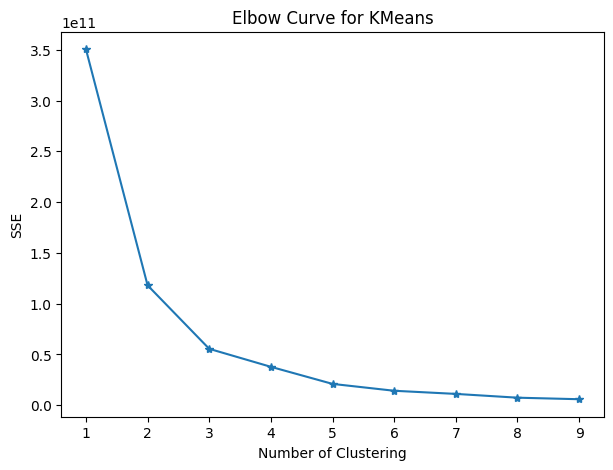

In [85]:
plt.figure(figsize=(7,5))
plt.plot(K, see, marker="*")
plt.title("Elbow Curve for KMeans")
plt.xlabel("Number of Clustering")
plt.ylabel("SSE")
plt.show()

In [86]:
k_final = 4
kmeans_final = KMeans(n_clusters=k_final, random_state=42)
clusters_final = kmeans_final.fit_predict(X_km_scaled)

In [87]:
model_df["Cluster_KMeans4"] = clusters_final

In [88]:
model_df.head(10)

,Recency,Frequency,Monetary,Cluster,Target,Cluster_KMeans4
CustomerID,,,,,,
12346.0,326,1,77183.60,1,0,3
12347.0,2,7,4310.00,0,1,0
12348.0,75,4,1797.24,0,1,0
12349.0,19,1,1757.55,0,1,0
12350.0,310,1,334.40,1,0,1
12352.0,36,8,2506.04,0,1,0
12353.0,204,1,89.00,1,0,1
12354.0,232,1,1079.40,1,0,1
12355.0,214,1,459.40,1,0,1


In [89]:
cluster_profile = model_df.groupby("Cluster_KMeans4")[["Recency", "Frequency", "Monetary"]].mean()
cluster_profile

,Recency,Frequency,Monetary
Cluster_KMeans4,,,
0,43.702685,3.682711,1359.049284
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


In [90]:
rfm_features = ["Recency", "Frequency", "Monetary"]

cluster_means = model_df.groupby("Cluster")[rfm_features].mean()
cluster_means

,Recency,Frequency,Monetary
Cluster,,,
0,40.983906,4.852677,2012.111620
1,246.023788,1.582800,631.141410
2,7.142857,80.214286,122888.407143


### ***Heatmap***

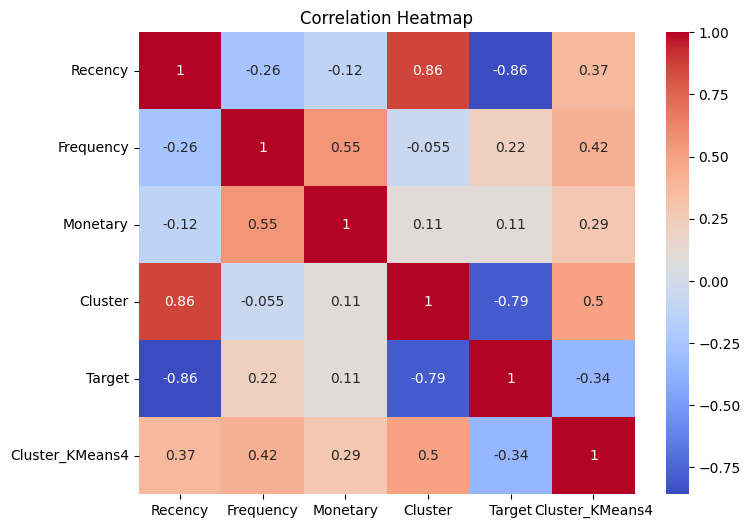

In [91]:
plt.figure(figsize=(8,6))
sns.heatmap(model_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### ***Scatter Plot***

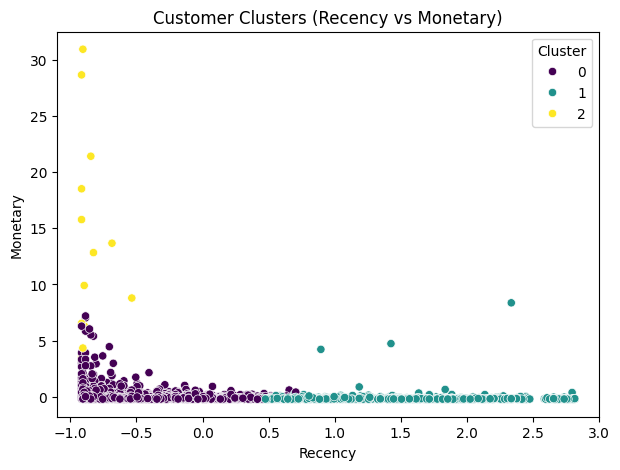

In [92]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=scaled_df["Recency"],
    y=scaled_df["Monetary"],
    hue=scaled_df["Cluster"],
    palette="viridis"
)
plt.title("Customer Clusters (Recency vs Monetary)")
plt.show()

In [93]:
mscaler = MinMaxScaler()
cluster_means_scaled = pd.DataFrame(
    mscaler.fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)

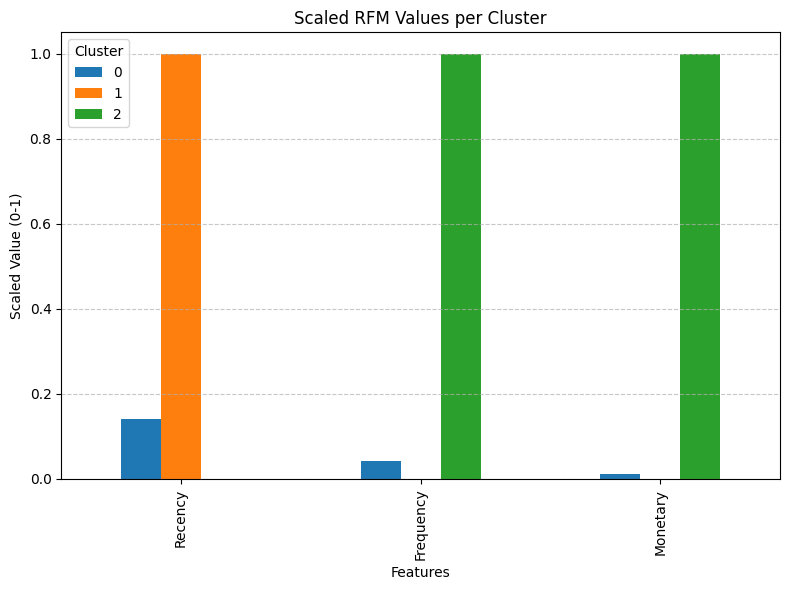

In [94]:
cluster_means_scaled.T.plot(kind="bar", figsize=(8,6))
plt.title("Scaled RFM Values per Cluster")
plt.xlabel("Features")
plt.ylabel("Scaled Value (0-1)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

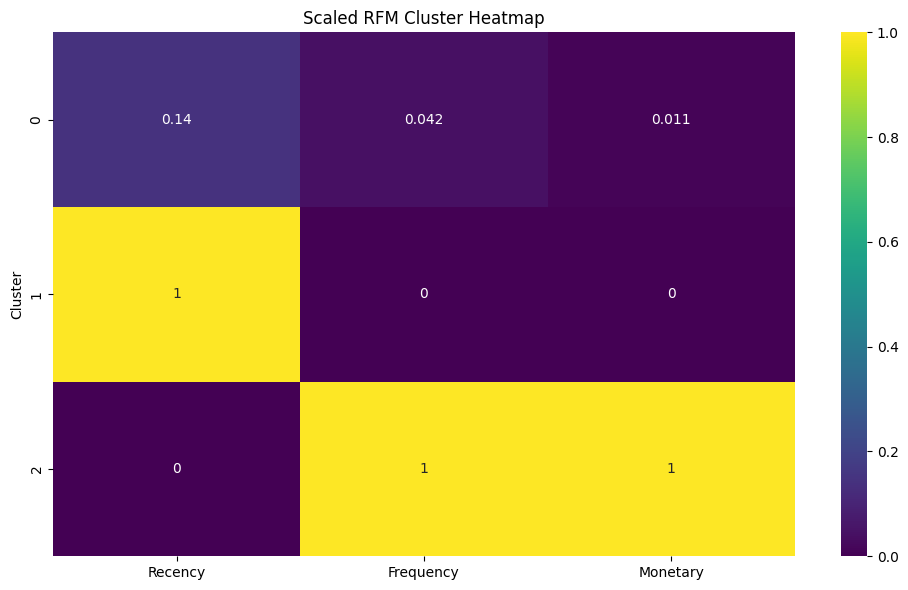

In [95]:
plt.figure(figsize=(10,6))
sns.heatmap(cluster_means_scaled, annot=True, cmap="viridis")
plt.title("Scaled RFM Cluster Heatmap")
plt.tight_layout()
plt.show()

### ***Two datasets are created:***
- ***Model_DF.csv (raw values)***
- ***Scaled_DF.csv (scaled RFM values)***
### ***These will be used in Notebook 03.***

In [96]:
model_df.to_csv("Model_DF.csv", index=True)
scaled_df.to_csv("Scaled_DF.csv", index=True)